<a href="https://colab.research.google.com/github/MatteoGuglielmi-tech/Polarity-and-Subjectivity-Detection/blob/main/src/MyModel/NTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NTN (Neural Tensor Network) [[reference_paper](https://proceedings.neurips.cc/paper/2013/file/b337e84de8752b27eda3a12363109e80-Paper.pdf)]

<u><i>Goal</i></u> : state if two entities $(e_1, e_2)$ are in a certain relationship $R$.   
>Ex. defines whehter $$(e_1, R, e_2) = (\text{Bengal tiger}, \text{has part}, \text{tail})$$ is true and with which certainty.

- $e_1$ and $e_2$ are vector representations or features of the two entities.
- NTN, unlike a linear canoncical NN layer, uses a bilinear tensor layer that directly relates two entity vectors across differet dimensions.
- Model computes a score of how likely it is two entities are in a specific position following : $$g(e_1, R, e_2) = u_R^Tf\biggr(e_i^T W_R^{[1:K]}e_2+V_R \begin{align}
    \begin{bmatrix}
           e_{1} \\
           e_{2} \\
         \end{bmatrix}
  \end{align} + b_R\Biggl)$$  
where : 
- $f=\tanh$
- $W_R^{[1:K]} \in \mathbb{R}^{d\times d\times k}$ is a multi-dimensional tensor
- $e_1^TW_R^{[1:k]}e_2=h\in\mathbb{R}$ is the bilinear tensor
- $V_R \in \mathbb{R}^{k\times2d}$, $U \in \mathbb{R}^K$, $b_R\in \mathbb{R}^K$ are NN parameters




##### pytorch trials

In [33]:
import torch
import torch.nn as nn
from typing import Tuple
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [35]:
class NeuralTensorNetwork(nn.Module):
    def __init__(self, output_dim: int, input_dim: int, activation: str="tanh", mean: float=0.0, std: float=1.0):
        
        super(NeuralTensorNetwork, self).__init__()

        # setting input and output dimensions
        self.k = output_dim
        self.d = input_dim # e1,e2

        # setting mean and std for random initialization
        self.mean = mean
        self.std = std

        self.activation = activation

        # parameters has been used in order to consider W, V, b as model parameters
        # inference -> they'll be optimized

        # normal sampling -> https://pytorch.org/docs/stable/generated/torch.normal.html
        # parameter -> https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
        self.W = nn.Parameter(torch.normal(self.mean, self.std, size=(self.k, self.d, self.d)))
        self.V = nn.Parameter(torch.normal(self.mean, self.std, size=(2*self.d, self.k)))
        self.b = nn.Parameter(torch.zeros(size=(self.d,)))
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif self.activation == 'relu':
            self.activation = nn.ReLU()
        # checking for a good activation function
        else:
            raise ValueError('Possible activation choices are tanh, sigmoid or ReLU')

    def forward(self, inputs: Tuple[torch.Tensor, torch.Tensor]):

        # getting the entities
        e1 = inputs[0]
        e2 = inputs[1]

        # input tensor should be of shape (batch_size, padded_length, 768)
        batch_size = e1[0]
        k = self.k
        d = self.d

        # bilinear tensor + bias
        bil_bias = [torch.sum((e2 * torch.dot(e1, self.W[0])) + self.b, axis=1)]
        for i in range(1,k):
            bil_bias.append(torch.sum((e2*torch.dot(e1, self.W[i]))) + self.b, axis=1)
        bil_bias = torch.reshape(torch.cat(bil_bias, axis=0), (batch_size, k))

        # Vr * [e1, e2]
        rest = torch.dot(torch.cat([e1,e2]), self.V)

        e1_R_e2 = bil_bias + rest

        # applying activation
        f = self.activation(e1_R_e2)
        return f

In [108]:
def batching_data(data: Tuple[np.array, np.array], batch_size: int=64) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    x1 = DataLoader(dataset=data, sampler=RandomSampler(data), batch_size=64, shuffle=False)
    #x2 = DataLoader(dataset=data[1], sampler=RandomSampler(data[1]), batch_size=64, shuffle=False)
    return x1#, x2 

In [39]:
import numpy as np


# Dummy training data
x_train1 = np.random.random((1000, 300))
x_train2 = np.random.random((1000, 300))
y_train = np.random.random((1000, 1))

# Dummy validation data
x_val1 = np.random.random((100, 300))
x_val2 = np.random.random((100, 300))
y_val = np.random.random((100, 1))


print ('Shape of Training Data: ', x_train1.shape, x_train2.shape, y_train.shape)
print ('Shape of Validation Data', x_val1.shape, x_val2.shape, y_val.shape)

Shape of Training Data:  (1000, 300) (1000, 300) (1000, 1)
Shape of Validation Data (100, 300) (100, 300) (100, 1)


In [46]:
x1, x2 = batching_data([x_train1, x_train2])

In [47]:
type(x1)

torch.utils.data.dataloader.DataLoader

In [48]:
type(x2)

torch.utils.data.dataloader.DataLoader

In [49]:
def get_mse() -> torch.nn.MSELoss:
    return nn.MSELoss()

In [50]:
def get_optimizer(model, lr):
    return torch.optim.Adam(model.parameters(), lr)

In [70]:
from dataclasses import dataclass

class MyModel(nn.Module):
    bilinear : NeuralTensorNetwork(output_dim=32, input_dim=300, activation='relu')
    g : nn.Linear(in_features=32, out_features=1)
    
    def forward(self, x):
        bilinear = bilinear(x)
        dense = g(bilinear)

        return dense


In [57]:
def training_step(model, data, optimizer, cf, targets, device='cuda'):
    samples = 0.
    cumulative_loss = 0.
    cumulative_accuracy = 0.
  
    model.train() 
 
    # iterate over the training set
    for batch_idx, inputs in enumerate(data):
        # load data into GPU
        input1 = inputs[0].to(device)
        input2 = inputs[1].to(device)
        inputs = [input1, input2]
        targets = targets.to(device)
        
        # forward pass
        outputs = model(inputs)

        # loss computation
        loss = get_mse(outputs, targets)

        # backward pass
        loss.backward()
    
        # parameters update
        optimizer.step()

        # gradients reset
        optimizer.zero_grad()

        # fetch prediction and loss value
        samples += inputs.shape[0]
        cumulative_loss += loss.item()
        _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

        # compute training accuracy
        cumulative_accuracy += predicted.eq(targets).sum().item()

    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [58]:
def main():
    model = NeuralTensorNetwork(output_dim=32, input_dim=300, activation='relu').to('cuda')
    optimizer = get_optimizer(model, 0.001)
    loss = get_mse()

    data = batching_data([x_train1, x_train2])

    for e in range(0,5):
        train_loss, train_accuracy = training_step(model, data, optimizer, loss, y_train, 'cuda')
        print(f"Training loss: {train_loss} \n Training accuracy: {train_accuracy}")


In [59]:
main()

TypeError: ignored

## Tensrflow Version

In [44]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import backend as K  # in keras simple computations are not handled directly but it relies on a well optimized tensor handler library
from keras.layers import Layer
from keras.layers import Input, Dense
from keras.models import Model

In [53]:
class NeuralTensorLayer(Layer):
    def __init__(self, output_dim, input_dim, activation= None):
        super().__init__()
        self.output_dim = output_dim #The k in the formula
        self.input_dim = input_dim   #The d in the formula
        self.activation = activation #The f function in the formula
        
    # called the first time call is called
    def build(self, input_shape):
        #The initialisation parameters
        self.mean = 0.0 
        self.stddev = 1.0
        dtype = 'float32'
        self.seed = 1
        
        #The output and the inut dimension
        k = self.output_dim
        d = self.input_dim
        
        #Initialise the variables to be trained. The variables are according to the
        #function defined.
        self.W = K.variable(K.random_normal((k,d,d), self.mean, self.stddev,
                               dtype=dtype, seed=self.seed))
        self.V = K.variable(K.random_normal((2*d,k), self.mean, self.stddev,
                               dtype=dtype, seed=self.seed))
        self.b = K.zeros((self.input_dim,))
        
        #Set the variables to be trained.
        self._trainable_weights = [self.W, self.V, self.b]
        
    def call(self, inputs):
        
        #Get Both the inputs
        e1 = inputs[0]
        e2 = inputs[1]

        #Get the batch size
        batch_size = K.shape(e1)[0]
        
        #The output and the inut dimension
        k = self.output_dim
        d = self.input_dim

        #The first term in the function which is the bilinear product is calculated here.
        first_term_k = [K.sum((e2 * K.dot(e1, self.W[0])) + self.b, axis=1)]
        for i in range(1, k):
            temp = K.sum((e2 * K.dot(e1, self.W[i])) + self.b, axis=1)
            first_term_k.append(temp)
        first_term = K.reshape(K.concatenate(first_term_k, axis=0), (batch_size, k))

        #The second term in the function is calculated here.
        second_term = K.dot(K.concatenate([e1,e2]), self.V)
        
        #Sum of the two terms to get the final function
        z =  first_term + second_term
 
        # The activation is selected here
        if (self.activation == None):
            return z
        elif (self.activation == 'tanh'):
            return K.tanh(z)
        elif (self.activation == 'relu'):
            return K.relu(z)
        else :
            print ('Activation not found')

In [54]:
import numpy as np


# Dummy training data
x_train1 = np.random.random((1000, 300))
x_train2 = np.random.random((1000, 300))
y_train = np.random.random((1000, 1))

# Dummy validation data
x_val1 = np.random.random((100, 300))
x_val2 = np.random.random((100, 300))
y_val = np.random.random((100, 1))

print ('Shape of Training Data: ', x_train1.shape, x_train2.shape, y_train.shape)
print ('Shape of Validation Data', x_val1.shape, x_val2.shape, y_val.shape)


Shape of Training Data:  (1000, 300) (1000, 300) (1000, 1)
Shape of Validation Data (100, 300) (100, 300) (100, 1)


In [55]:
#Here Define the model
vector1 = Input(shape=(300,), dtype='float32')
vector2 = Input(shape=(300,), dtype='float32')
BilinearLayer = NeuralTensorLayer(output_dim=32, input_dim=300, 
                                  activation= 'relu')([vector1, vector2])

g = Dense(1)(BilinearLayer)

#The g or the output of the modelled function.
model = Model(inputs=[vector1, vector2], outputs=[g])

#Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)
#The summary of the model.
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 neural_tensor_layer_12 (Neural  (None, 32)          2899500     ['input_25[0][0]',               
 TensorLayer)                                                     'input_26[0][0]']               
                                                                                                  
 dense_10 (Dense)               (None, 1)            33          ['neural_tensor_layer_12[0]

In [56]:
model.fit([x_train1, x_train2], y_train,
          batch_size=64, epochs=10,
          validation_data=([x_val1, x_val2], y_val))

Epoch 1/10
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
 1/16 [>.............................] - ETA: 36s - loss: 24450.2891<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
 4/16 [======>.......................] - ETA: 0s - loss: 14604.1045 <class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
 7/16 [============>.................] - ETA: 0s - loss: 9383.4521 <class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<c

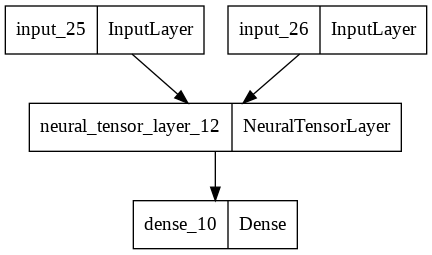

In [57]:
from keras.utils.vis_utils import plot_model

plot_model(model)